# Assignment 1 (part II):  Automatic Panorama Mosaicing

In [52]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from skimage.feature import (corner_harris, corner_peaks, plot_matches, BRIEF, match_descriptors)
from skimage.transform import warp, ProjectiveTransform
from skimage.color import rgb2gray
from skimage.measure import ransac

### The cell below demonstrates feature detection (e.g. corners) and matching (e.g. BRIEF descriptor) 

the number of matches is 56


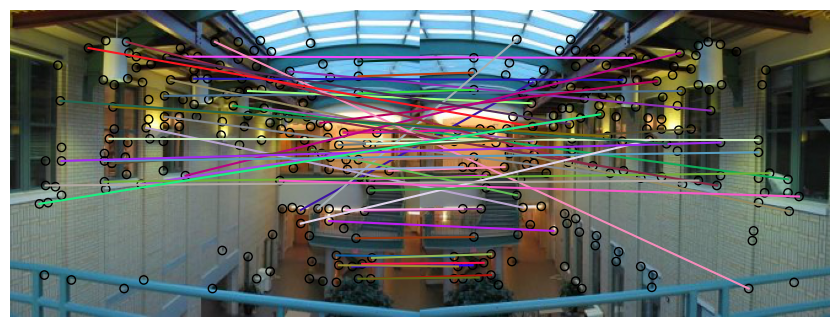

In [53]:
imL = image.imread("images/CMU_left.jpg")
imR = image.imread("images/CMU_right.jpg")
imLgray = rgb2gray(imL)
imRgray = rgb2gray(imR)

# NOTE: corner_peaks and many other feature extraction functions return point coordinates as (y,x), that is (rows,cols)
keypointsL = corner_peaks(corner_harris(imLgray), threshold_rel=0.0005, min_distance=5)
keypointsR = corner_peaks(corner_harris(imRgray), threshold_rel=0.0005, min_distance=5)

extractor = BRIEF()

extractor.extract(imLgray, keypointsL)
keypointsL = keypointsL[extractor.mask]         
descriptorsL = extractor.descriptors

extractor.extract(imRgray, keypointsR)
keypointsR = keypointsR[extractor.mask]
descriptorsR = extractor.descriptors

matchesLR = match_descriptors(descriptorsL, descriptorsR, cross_check=True)

print ('the number of matches is {:2d}'.format(matchesLR.shape[0]))

fig = plt.figure(1,figsize = (12, 4))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matchesLR) #, matches_color = 'r')
axA.axis('off')

plt.show()

## Problem 1
### Rederive your formula in Problem 4a from Part I of the assignment for the following modification. Assume there are $N=53$ matches $(p,p')$ as in figure 1 above. $N_i=21$ of these matches are inliers for a homography, while the rest of the matches are $N_o=32$ outliers. To estimate a homography you need a sample with $K=4$ matches. What is the least number of times one should randomly sample a subset of $K$ matches to get probability  $p≥0.95$  that at least one of these samples has all of its $K$ matches from inliers? Derive a general formula and compute a numerical answer for the specified numbers.

Solution:
Let $X$ be the number of matches.

$
0.95 \geq 1-(1-(1-\frac{N_o}{N})^4)^X \\
X \geq \frac{\ln(0.05)}{\ln(1-(1-\frac{N_o}{N})^)} \\
X \geq \frac{\ln(0.05)}{\ln(1-(1-\frac{32}{53})^4)} = 120 \\
X = 120
$

## Problem 2: (RANSAC for Homographies)
### Write code below using RANSAC to estimate Homography from matched pairs of points above. This cell should display new figure 2 similar to figure 1 above, but it should show only inlier pairs for the detected homography. HINT: you can use $ProjectiveTransform$  from library $skimage$ declared at the top of the notebok.

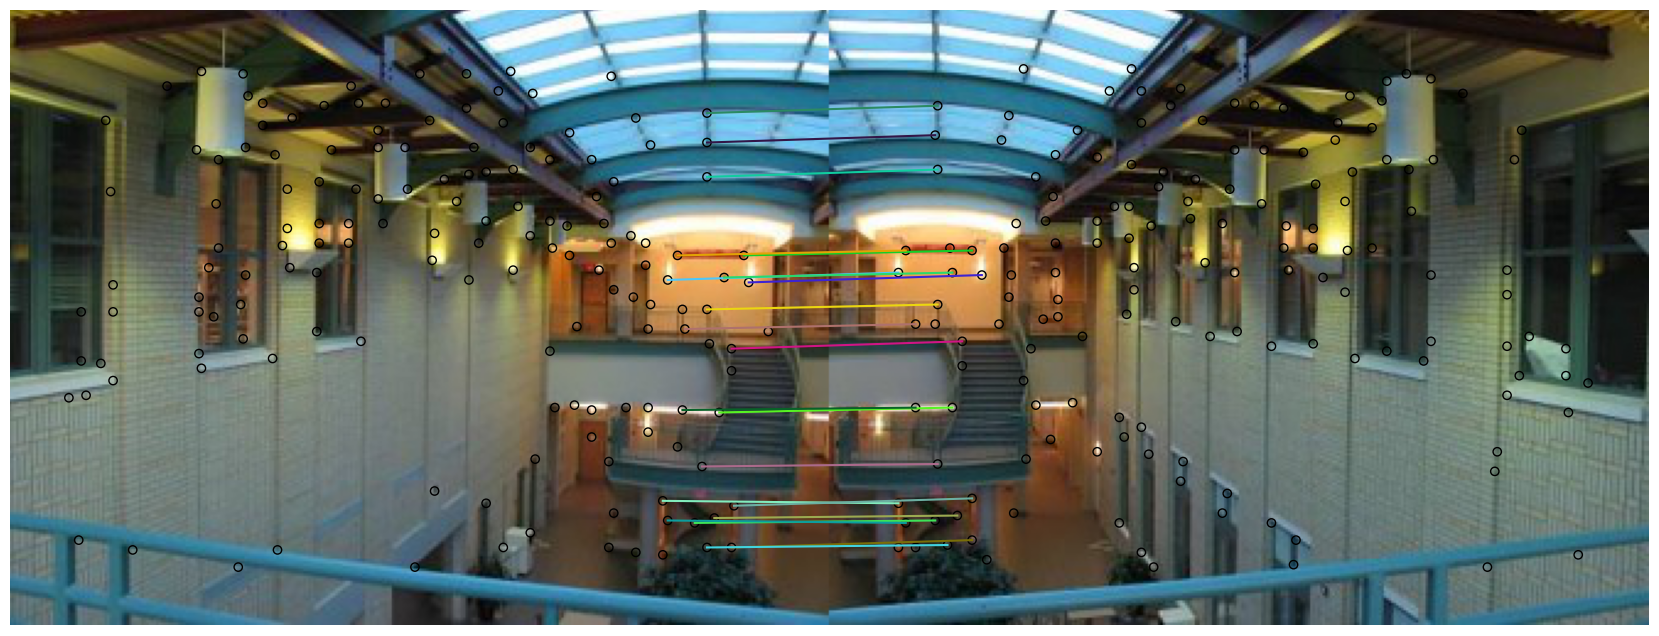

In [80]:
l_img = keypointsL[matchesLR[:,0]][:,[1, 0]]
r_img = keypointsR[matchesLR[:,1]][:,[1, 0]]

model_robust, inliers = ransac((l_img, r_img), 
                                ProjectiveTransform, min_samples=4, residual_threshold=10, max_trials=20)

matched = matchesLR[inliers]

fig = plt.figure(2,figsize = (24, 8))
axA = plt.subplot(111)
plt.gray()
plot_matches(axA, imL, imR, keypointsL, keypointsR, matched)
axA.axis('off')
plt.show()

## Problem 3 (reprojecting onto common PP)
### Use common PP corresponding to the plane of the left image. Your pamorama mosaic should be build inside a "reference frame" (think about it as an empty canvas of certain size) inside this common PP. The reference frame should be big enough to contain the left image and the part of the view covered by the right image after reprojecting onto common PP. Create a new figure 3 including the following three images (spread them vertically). First, show your reference frame only with the left image inside. Second, show the reference frame containing only a reprojected right image (warp it using a homography computed in Problem 1). Third, for comparison, show the reference frame containing only the right image reprojected using a (bad) homography estimated from all matches (including outliers, as in figure 1).
#### HINT1: use function $warp$ from library $skimage$ declared at the top of the notebook. 
#### HINT2: function $warp$ needs "inverse map" as a (second) argument as it uses "inverse warping" to compute output intensities

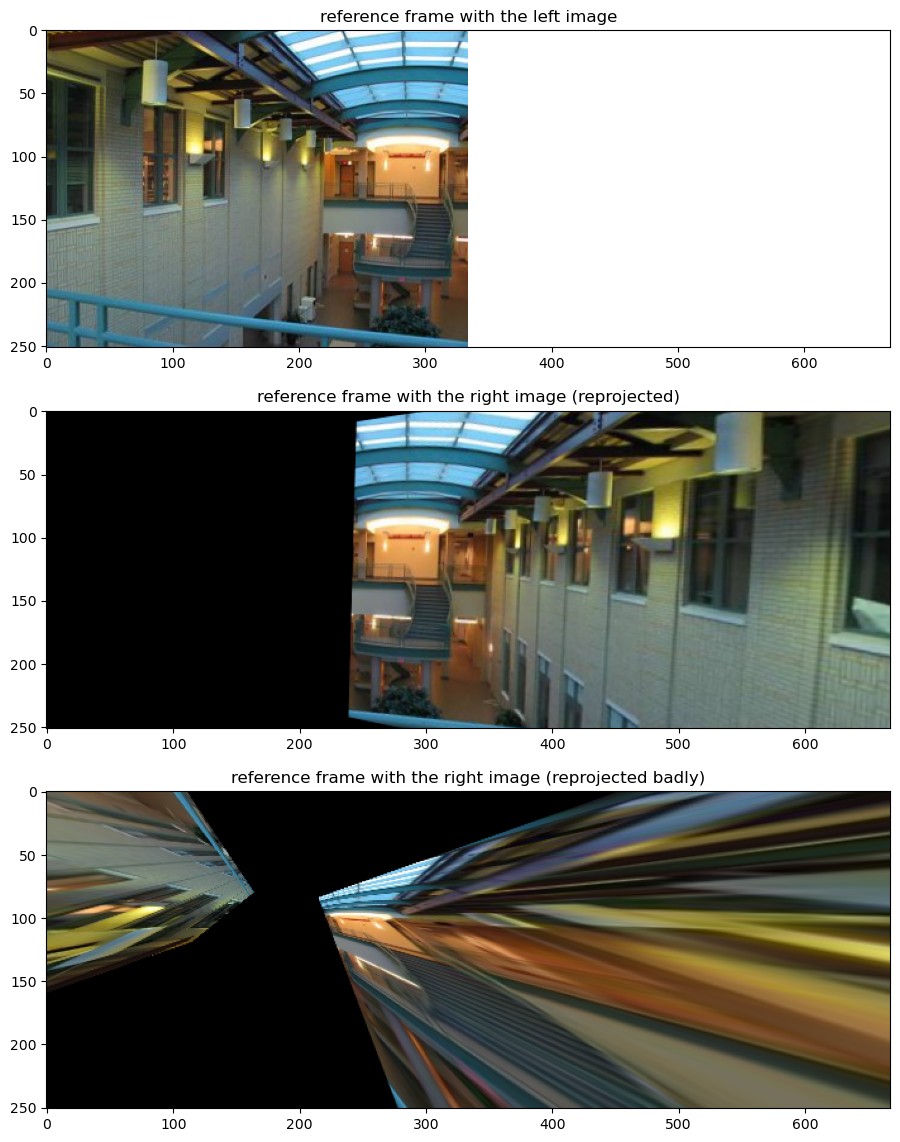

In [86]:
fig = plt.figure(3,figsize = (12, 14))
plt.subplot(311)
plt.axis([0, 2*imL.shape[1], imL.shape[0], 0])
plt.imshow(imL)
plt.title("reference frame with the left image")

plt.subplot(312)
imR_warp = warp(imR, model_robust.params, output_shape=(imL.shape[0], 2*imL.shape[1]))
plt.imshow(imR_warp)
plt.title("reference frame with the right image (reprojected)")

im_transform = ProjectiveTransform()
im_transform.estimate(l_img, r_img)

plt.subplot(313)
plt.imshow(warp(imR, im_transform, output_shape=(imL.shape[0], 2*imL.shape[1])))
plt.title("reference frame with the right image (reprojected badly)")

plt.show()

## Problem 4 (blending)

### (part a) Write code for a function below computing distance transform for the boundary of a given image. It returns a numpy array of the same size as the image with distances from each pixel to the closest point on the boundary of the image (float values). 
   

In [179]:
def boundaryDT(image):
    r1 = np.arange(image.shape[0])
    r2 = np.arange(image.shape[1])

    d1 = np.minimum(r1, r1[::-1])
    d2 = np.minimum(r2, r2[::-1])

    dist = np.minimum.outer(d1, d2)
    return np.divide(dist, dist.argmax())

### (part b) Use function from part (a) to compute a distance transform for both images. Create a new figure 4 showing the following two images. First, show reference frame containing only the left image's boundaryDT instead of the left image. Second, show reference frame containing only the right image's boundaryDT reprojected instead of the right image. 

Text(0.5, 1.0, 'Right image DT in Ref. frame (RdtRef)')

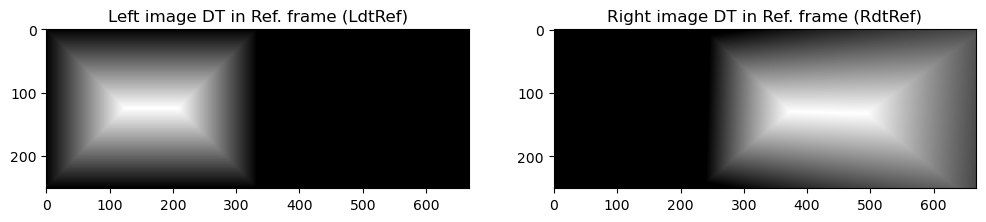

In [180]:
fig = plt.figure(4,figsize = (12, 3))
l_grad = warp(boundaryDT(imL), inverse_map=np.eye(3), output_shape=(imL.shape[0], 2*imL.shape[1]))
plt.subplot(121)
plt.axis([0, 2*imL.shape[1], imL.shape[0], 0])
plt.imshow(l_grad, cmap='gray')
plt.title("Left image DT in Ref. frame (LdtRef)")


imR_grad = warp(boundaryDT(imR), model_robust.params, output_shape=(imL.shape[0], 2*imL.shape[1]))
plt.subplot(122)
plt.imshow(imR_grad, cmap='gray')
plt.title("Right image DT in Ref. frame (RdtRef)")

### (part c) Use boundary distance transforms to blend left and right images (reprojected) into the reference frame. Create a new figure 5 showing the following three images. The first and second images should be smooth $alpha$'s suitable for blending the left and right images (e.g. based on distance transforms as discussed in class). The third image should be your panorama: left and (reprojected) right images blended inside the reference frame. Your panorama should also show (reprojected) features - homography inliers - from both left and right images. Use different colors/shapes to distinct features from the left and the right images.

C:\Users\HP\AppData\Local\Temp\ipykernel_20572\186063864.py:4: RuntimeWarning: invalid value encountered in divide
  a_l = np.divide(l_grad_adj, np.add(l_grad_adj, r_grad))
C:\Users\HP\AppData\Local\Temp\ipykernel_20572\186063864.py:5: RuntimeWarning: invalid value encountered in divide
  a_r = np.divide(r_grad, np.add(l_grad_adj, r_grad))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


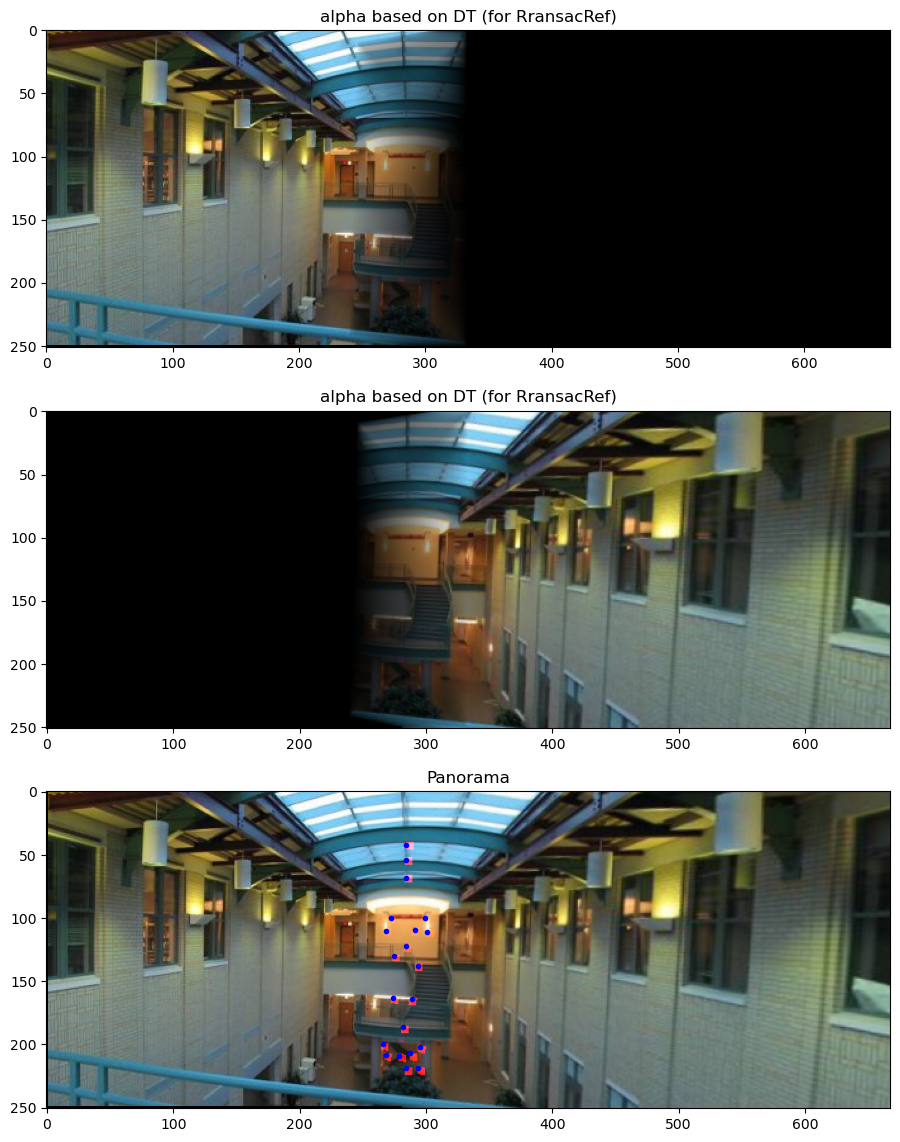

In [214]:
l_grad_adj = np.stack([l_grad, l_grad, l_grad], axis=-1)
r_grad = np.stack([imR_grad, imR_grad, imR_grad], axis=-1)

a_l = np.divide(l_grad_adj, np.add(l_grad_adj, r_grad))
a_r = np.divide(r_grad, np.add(l_grad_adj, r_grad))

l_adj = warp(imL, inverse_map=np.eye(3), output_shape=(imL.shape[0], 2*imL.shape[1]))
l_img_grad = np.multiply(l_adj, a_l)

red_points_img = np.zeros(shape=(imR.shape[0], imR.shape[1], 3))
for point in keypointsR[matched[:,1]]:
    red_points_img[point[0]:(point[0]+5), point[1]:point[1]+5] = [255, 0, 0]

red_points_warp = warp(red_points_img, inverse_map=model_robust, output_shape=(imL.shape[0], imL.shape[1]*2))
l_points = keypointsL[matched[:,0]][:,[1, 0]]
fig = plt.figure(5,figsize = (12, 14))
plt.subplot(311)
plt.axis([0, 2*imL.shape[1], imL.shape[0], 0])
plt.imshow(l_img_grad)
plt.title("alpha based on DT (for RransacRef)")


r_img_grad = np.multiply(imR_warp, a_r)
plt.subplot(312)
plt.imshow(r_img_grad)
plt.title("alpha based on DT (for RransacRef)")

pan = np.add(np.add(l_img_grad, r_img_grad), red_points_warp)

axD = plt.subplot(313)
plt.imshow(pan)
plt.plot(l_points[:, 0], l_points[:, 1], '.b')
plt.title("Panorama")

plt.show()